<a href="https://colab.research.google.com/github/tr41z/machine-learning/blob/main/AI_RAD_SL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 **Threat Detection using UNSW-NB15 Dataset** 🔐

In this notebook, I’ll be building an **threat detection model** using the **UNSW-NB15 dataset**. The main objective is to detect unusual or unexpected patterns in network traffic that could represent potential security threats.

### 🛠️ **Tools and Libraries I'll Use:**
- **Python** for data preprocessing and model building.
- **scikit-learn** and optionally **TensorFlow/PyTorch** for machine learning algorithms to identify anomalies.
- **Pandas** and **NumPy** for data manipulation and processing.
- **Matplotlib** and **Seaborn** for visualizing the data and results.

### 📊 **Dataset Overview:**
The **UNSW-NB15** dataset includes both normal and abnormal network traffic, making it ideal for threat detection. I'll be working with:
- **49 features** that describe various aspects of network traffic.
- A combination of normal and anomalous traffic data, allowing the model to learn the difference between the two.

By the end of this notebook, I'll have trained and evaluated a machine learning model that can detect anomalies in network traffic, which could be used for tasks like intrusion detection or identifying unusual network activity.

In [ ]:
!nvidia-smi

Thu Oct 24 17:42:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 🧸 Getting familiar with data

### 📦 **Importing Necessary Libraries**

> In this section, I’m importing the libraries that will be used for `data manipulation`, `visualization`, `preprocessing`, and `machine learning`.


In [ ]:
!pip install dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import logging

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

# Data encoding, preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
import plotly.express as px

# Machine learning
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils import resample

### 🫙 Mounting google drive to get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 📚 Reading data and visualising, analysing it

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/UNSW_NB15_training-set.csv'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/UNSW_NB15_testing-set.csv'

train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

In [ ]:
df = pd.concat([train_data,test_data]).drop('id',axis=1)
df = df.reset_index(drop=True)

df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


# 💡 Data Preprocessing

In [ ]:
df['state'].unique()

array(['FIN', 'INT', 'CON', 'ECO', 'REQ', 'RST', 'PAR', 'URN', 'no',
       'ACC', 'CLO'], dtype=object)

In [ ]:
# Convert 'state' column to categorical type and store the original categories
df['state'] = df['state'].astype('category')
original_states = df['state'].cat.categories.tolist()  # Store original categories

In [ ]:
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes

df['state'] = df['state'].replace(10, -1)
df['attack_cat'] = df['attack_cat'].astype('category')

In [ ]:
df['attack_cat'].unique()

['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode', 'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']
Categories (10, object): ['Analysis', 'Backdoor', 'DoS', 'Exploits', ..., 'Normal', 'Reconnaissance',
                          'Shellcode', 'Worms']

In [ ]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
# Filter for reconnaissance attacks
df = df[df['attack_cat'].isin(['Reconnaissance', 'Normal'])]

In [ ]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
# Separate the classes
normal_df = df[df['label'] == 0]
recon_df = df[df['label'] == 1]

# Determine the number of instances to keep from the normal class
n_recon = recon_df.shape[0]
normal_sampled = normal_df.sample(n=n_recon, random_state=42)  # Randomly sample normal instances

# Combine the sampled normal instances with the reconnaissance instances
balanced_df = pd.concat([normal_sampled, recon_df])

# Shuffle the dataset to mix the classes
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
balanced_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.998379,113,0,4,34,10,34230,440,43.069817,254,...,1,3,0,0,0,1,3,0,Normal,0
1,0.630218,113,0,4,10,8,564,354,26.974792,254,...,1,1,0,0,0,1,1,0,Reconnaissance,1
2,0.000010,120,0,5,2,0,200,0,100000.002500,254,...,4,14,0,0,0,5,12,0,Reconnaissance,1
3,0.000002,125,0,5,2,0,200,0,500000.001300,254,...,2,13,0,0,0,4,9,0,Reconnaissance,1
4,0.671291,113,0,4,10,8,564,354,25.324338,254,...,1,1,0,0,0,1,1,0,Reconnaissance,1


In [ ]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27974 entries, 0 to 27973
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                27974 non-null  float64 
 1   proto              27974 non-null  int16   
 2   service            27974 non-null  int8    
 3   state              27974 non-null  int8    
 4   spkts              27974 non-null  int64   
 5   dpkts              27974 non-null  int64   
 6   sbytes             27974 non-null  int64   
 7   dbytes             27974 non-null  int64   
 8   rate               27974 non-null  float64 
 9   sttl               27974 non-null  int64   
 10  dttl               27974 non-null  int64   
 11  sload              27974 non-null  float64 
 12  dload              27974 non-null  float64 
 13  sloss              27974 non-null  int64   
 14  dloss              27974 non-null  int64   
 15  sinpkt             27974 non-null  float64 
 16  dinp

In [ ]:
balanced_df.describe()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,2.797400e+04,2.797400e+04,27974.000000,...,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000,27974.000000
mean,0.991955,110.789698,1.072424,4.142632,17.055623,18.485344,2398.867448,1.323522e+04,5.973663e+04,173.482984,...,1.508186,1.184207,2.967577,0.007114,0.007257,0.140774,3.353221,3.728426,0.019375,0.500000
std,4.713409,19.505395,2.195201,0.921253,39.218730,84.076487,10487.508152,1.107526e+05,1.403064e+05,106.921694,...,1.844756,1.318857,4.629379,0.084044,0.086133,0.539759,4.330775,4.664353,0.137842,0.500009
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,24.000000,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000009,113.000000,0.000000,4.000000,2.000000,0.000000,168.000000,0.000000e+00,2.296783e+01,31.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,0.066776,113.000000,0.000000,4.000000,10.000000,6.000000,564.000000,3.040000e+02,4.315151e+02,254.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.500000
75%,0.805162,119.000000,0.000000,5.000000,10.000000,8.000000,1064.000000,6.780000e+02,1.000000e+05,254.000000,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,1.000000
max,59.999935,132.000000,11.000000,8.000000,818.000000,5254.000000,338718.000000,7.085342e+06,1.000000e+06,255.000000,...,46.000000,46.000000,65.000000,1.000000,2.000000,16.000000,46.000000,62.000000,1.000000,1.000000


In [ ]:
X = balanced_df.drop(columns = ['attack_cat', 'label', 'ct_state_ttl', 'sttl', 'ct_dst_src_ltm', 'ct_dst_ltm', 'ct_srv_dst', 'ct_srv_src', 'state', 'sloss', 'dloss'])
y = balanced_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19581, 33), (19581,), (8393, 33), (8393,))

### 🖊️ Visualising some data

attack_cat
Normal            13987
Reconnaissance    13987
Name: count, dtype: int64


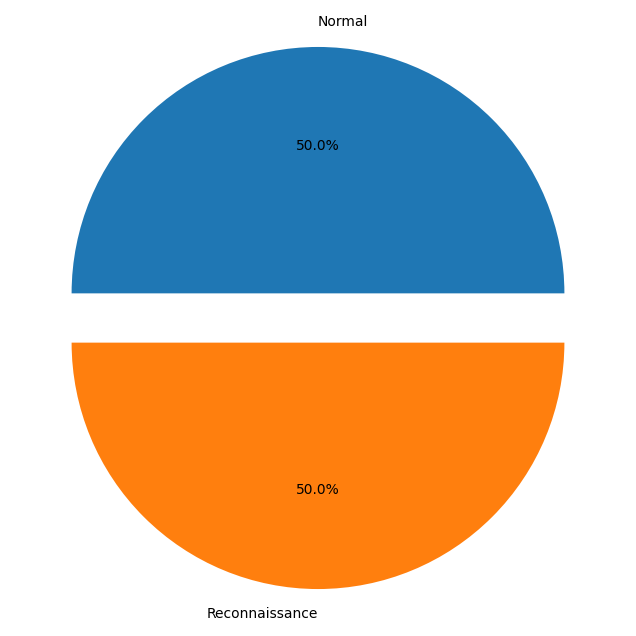

In [ ]:
# Get valid attacks counts, including normal
validAttacks = balanced_df['attack_cat'].value_counts()

# Exclude categories with zero counts from the pie chart
validAttacks = validAttacks[validAttacks > 0]

print(validAttacks)

# Prepare explode list with same length as validAttacks
explode = [0.1] * len(validAttacks)  # Slightly explode all slices for visibility

plt.figure(figsize=(15, 8))
plt.pie(validAttacks, labels=validAttacks.index, autopct='%1.1f%%', explode=explode)
plt.show()

1    9794
0    9787
Name: count, dtype: int64


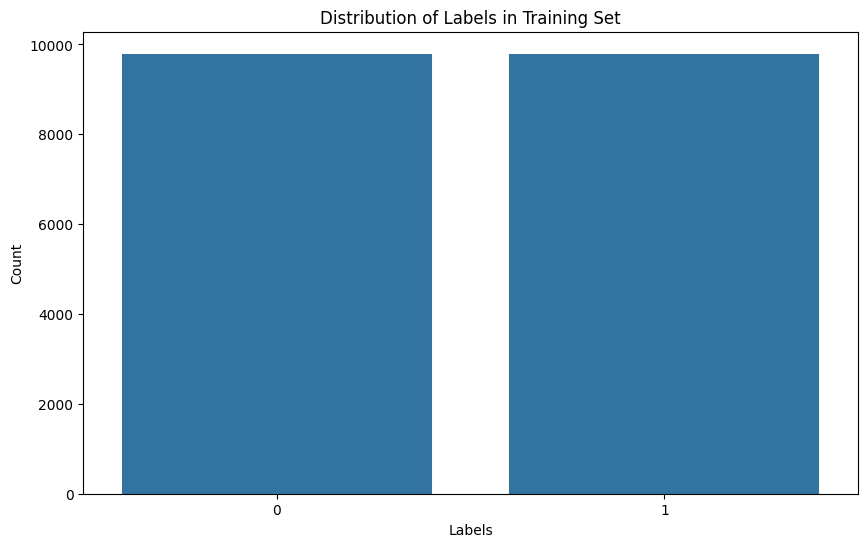

In [ ]:
# Convert y_train to a pandas Series
y_train_series = pd.Series(y_train)

# Count the occurrences of each label
label_counts = y_train_series.value_counts()

print(label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

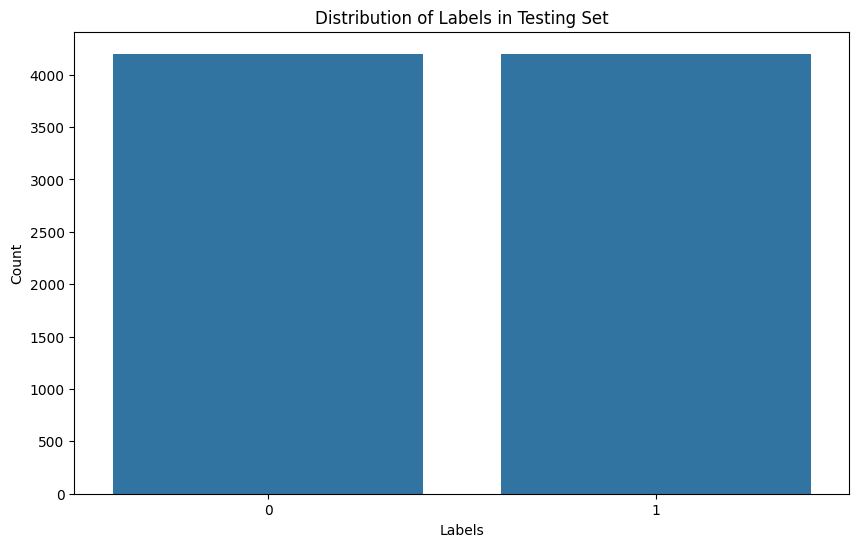

In [ ]:
# Convert y_train to a pandas Series
y_test_series = pd.Series(y_test)

# Count the occurrences of each label
label_counts = y_test_series.value_counts()

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in Testing Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# 🤖 Machine Learning

### 🌲 **Fitting a Random Forest Model and Evaluating Performance**

> In this step, I trained a **RandomForestClassifier** with 100 estimators and used it to predict the test set outcomes.

- **Model Accuracy**: I calculated the overall accuracy to assess how well the model is performing.
- **Classification Report**: The detailed classification report includes:
  - **Precision**: How many of the predicted positives were correct.
  - **Recall**: How many actual positives were correctly predicted.
  - **F1-Score**: The balance between precision and recall.

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19581, 33), (19581,), (8393, 33), (8393,))

In [ ]:
def model_evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Print the metrics
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cross = pd.crosstab(pd.Series(y_test, name='Actual'),
                        pd.Series(y_pred, name='Predicted'))

    # Calculate percentages
    cross_percent = (cross / cross.sum().sum() * 100).round(2)

    # Create annotations with both percentages and counts
    annotations = cross_percent.astype(str) + "%\n" + cross.astype(str)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cross, annot=annotations, fmt='', cmap="coolwarm", cbar=False,
                linewidths=1, linecolor='black', annot_kws={"size": 12})

    # Add labels and title
    plt.title('Confusion Matrix with Percentage and Counts', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('Actual Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    return {'Recall': recall, 'Precision': precision, 'Accuracy': accuracy}

In [ ]:
results = {}

Recall: 0.9924
Precision: 0.9924
Accuracy: 0.9924


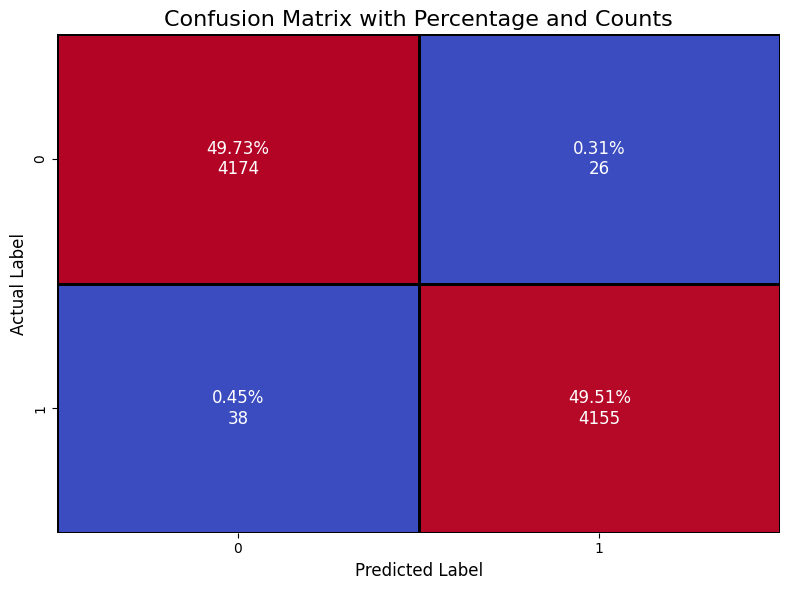

In [ ]:
rf = RandomForestClassifier(random_state=42)

results['Random Forest Model'] = model_evaluation(rf)

# 🔑 Trying to improve model by applying the same strategy, but for different models

### 🔧 XGBClassifier



In [ ]:
results = {}

Recall: 0.9943
Precision: 0.9943
Accuracy: 0.9943


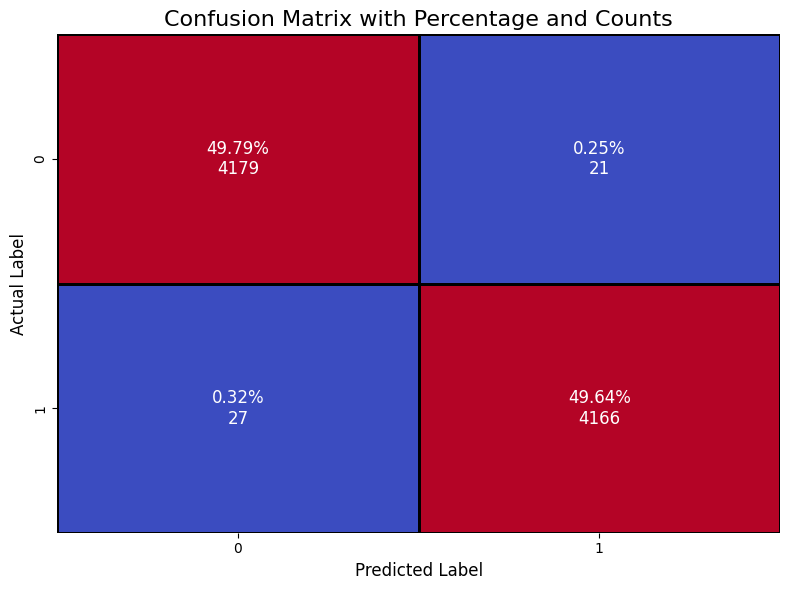

In [ ]:
xgbc = XGBClassifier()

results['XGBoost Classifier'] = model_evaluation(xgbc)

# ❗️ Trying to visualise and inspect feature importance

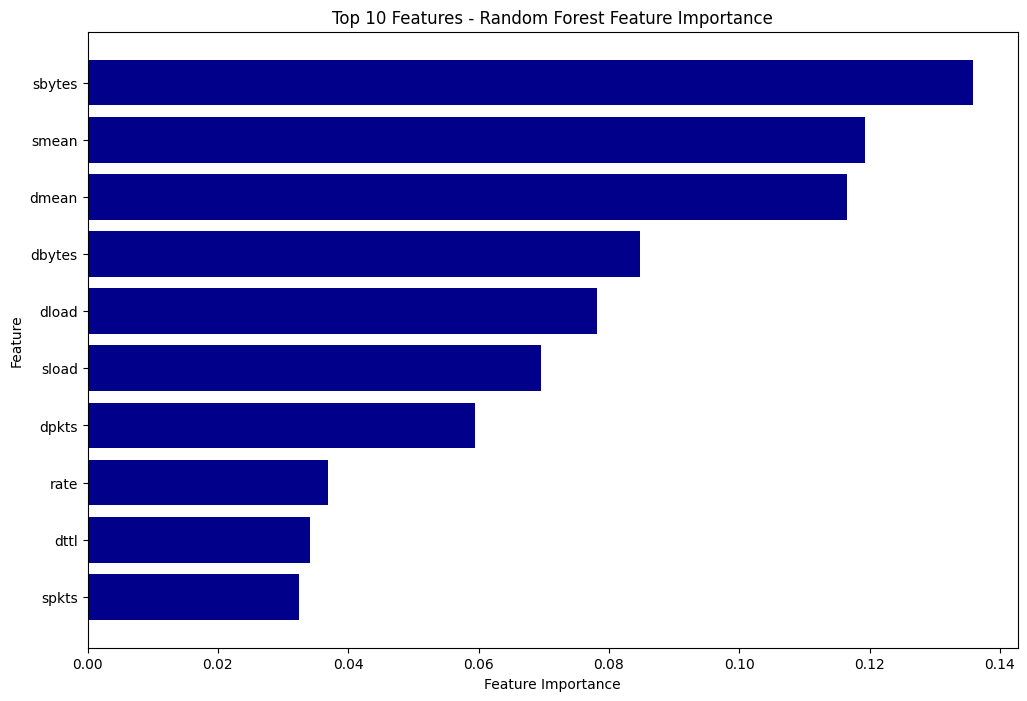

In [ ]:
# Get feature names
feature_names = list(X.columns)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_n = 10
top_features = feature_importance_df.head(top_n)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='darkblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features - Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [ ]:
# Extract feature importances into a dictionary and sort
feature_importances = dict(zip(X.columns, rf.feature_importances_))
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame from sorted importances
feature_imp_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Apply gradient and display top 10 important features
feature_imp_df.head(10).style.background_gradient()

,Feature,Importance
0,sbytes,0.135895
1,smean,0.119276
2,dmean,0.116511
3,dbytes,0.084749
4,dload,0.078149
5,sload,0.069527
6,dpkts,0.059386
7,rate,0.036972
8,dttl,0.034172
9,spkts,0.032488


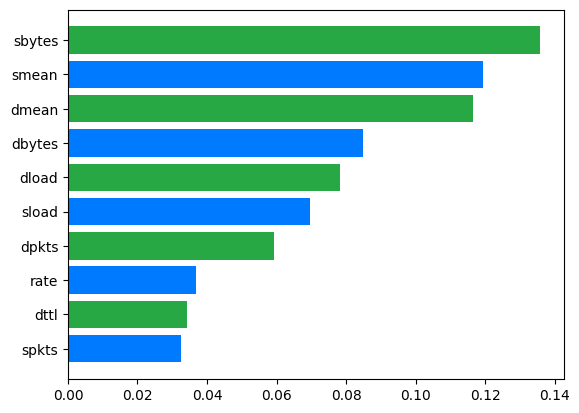

In [ ]:
# Plot top 10 important features
top_10_features = feature_imp_df['Feature'][:10]
top_10_importances = feature_imp_df['Importance'][:10]
plt.barh(top_10_features, top_10_importances, color=['#28a745', '#007bff'] * 5)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Select top 10 features and create a new dataset
top_10_features = feature_imp_df['Feature'][:10].values
X_top10 = df[top_10_features]
y_top10 = df['label'].to_numpy()

In [ ]:
X_top10.head()

,sbytes,smean,dmean,dbytes,dload,sload,dpkts,rate,dttl,spkts
0,258,43,43,172,8495.365234,14158.942380,4,74.087490,254,6
1,734,52,1106,42014,503571.312500,8395.112305,38,78.473372,252,14
2,364,46,824,13186,60929.230470,1572.271851,16,14.170161,252,8
3,628,52,64,770,3358.622070,2740.178955,12,13.677108,252,12
4,534,53,45,268,3987.059814,8561.499023,6,33.373826,252,10


In [ ]:
X_top10['dttl'].unique()

array([254, 252,   0,  29,  60,  31,  30,  32, 253])

In [ ]:
# filtered_df = df[df['label'] == 1]
# filtered_df_top10 = filtered_df[top_10_features]
# filtered_df_top10.head()

In [ ]:
print(y_top10)

[0 0 0 ... 0 0 0]


0    93000
1    13987
Name: count, dtype: int64


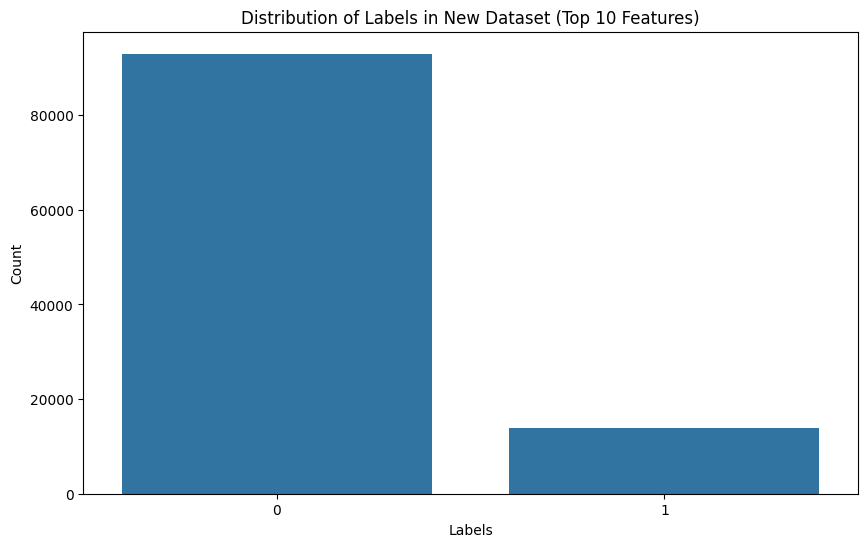

In [ ]:
y_top10_series = pd.Series(y_top10)  # Convert to pandas Series for easier counting

# Count occurrences of each label
label_counts = y_top10_series.value_counts()

# Print the label counts
print(label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.title('Distribution of Labels in New Dataset (Top 10 Features)')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [ ]:
# # Separate majority and minority classes
# df_majority = df[df.label == 0]
# df_minority = df[df.label == 1]

# # Downsample majority class
# df_majority_downsampled = resample(df_majority,
#                                     replace=False,     # sample without replacement
#                                     n_samples=len(df_minority),    # to match minority class
#                                     random_state=42)  # reproducible results

# # Combine minority class with downsampled majority class
# df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
# # Count occurrences of each label in the balanced dataset
# label_counts_balanced = df_balanced['label'].value_counts()

# # Print the label counts for the balanced dataset
# print("Label counts after balancing:")
# print(label_counts_balanced)

# # Plot the label distribution of the balanced dataset
# plt.figure(figsize=(10, 6))
# sns.barplot(x=label_counts_balanced.index.astype(str), y=label_counts_balanced.values)
# plt.title('Distribution of Labels in Balanced Dataset')
# plt.xlabel('Labels')
# plt.ylabel('Count')
# plt.xticks(rotation=0)  # Rotate x-axis labels if needed
# plt.show()

In [ ]:
# Create the new features and labels for balanced dataset
X = df[top_10_features]
y = df['label'].to_numpy()

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
# Train a new RandomForest on the top 10 features
rf_top10_model = RandomForestClassifier(random_state=42)

rf_top10_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_top10_model.predict(X_test)

accuracy_top10 = accuracy_score(y_test, y_pred)
recall_top10 = recall_score(y_test, y_pred)
precision_top10 = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy_top10}")
print(f"Recall: {recall_top10}")
print(f"Precision: {precision_top10}")

Accuracy: 0.9899367542137895
Recall: 0.9566460219151978
Precision: 0.9660813086360356


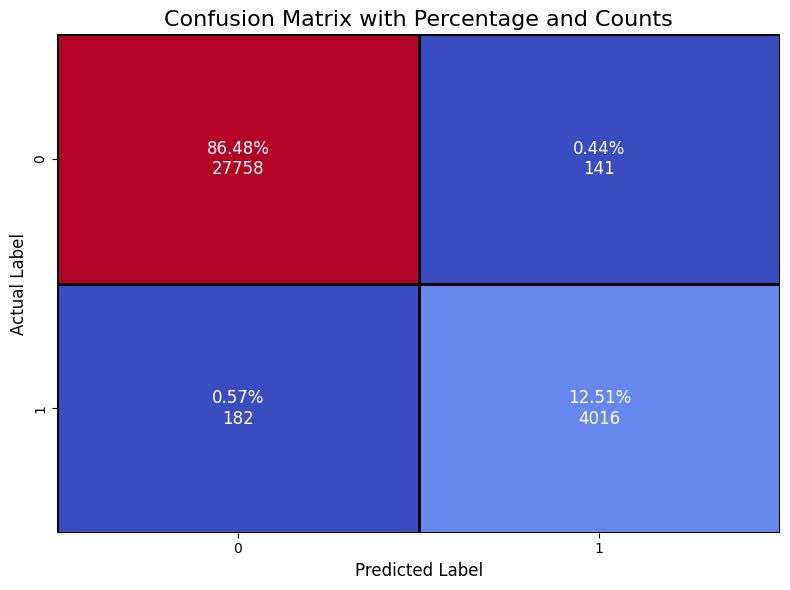

In [ ]:
# Confusion matrix
cross_top10 = pd.crosstab(pd.Series(y_test, name='Actual'),
                    pd.Series(y_pred, name='Predicted'))

# Calculate percentages
cross_percent_top10 = (cross_top10 / cross_top10.sum().sum() * 100).round(2)

# Create annotations with both percentages and counts
annotations_top10 = cross_percent_top10.astype(str) + "%\n" + cross_top10.astype(str)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cross_top10, annot=annotations_top10, fmt='', cmap="coolwarm", cbar=False,
            linewidths=1, linecolor='black', annot_kws={"size": 12})

# Add labels and title
plt.title('Confusion Matrix with Percentage and Counts', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.tight_layout()
plt.show()

# 🔧 Fine Tuning

In [ ]:
malicious_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/Fine-Tuning/Malicious/Malicious.csv'
benign_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/Fine-Tuning/Benign/Benign.csv'

malicious_data = pd.read_csv(malicious_dir)
benign_data = pd.read_csv(benign_dir)

In [ ]:
# Add 'label' column with value 1 for malicious data
malicious_data['label'] = 1
benign_data['label'] = 0

In [ ]:
malicious_data.head()

,id,src_ip,src_port,dst_ip,dst_port,protocol,total_bytes,total_packet_count,sbytes,smean,...,dload,sload,dpkts,rate,dttl,spkts,start_time,last_updated_time,dur,label
0,538,192.168.1.103,34080,192.168.1.102,2146,6,60,1,60,60,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
1,539,192.168.1.103,53038,192.168.1.102,1171,6,60,1,60,60,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
2,540,192.168.1.103,49096,192.168.1.102,3664,6,60,1,60,60,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
3,541,192.168.1.103,60896,192.168.1.102,2054,6,60,1,60,60,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
4,542,192.168.1.103,50644,192.168.1.102,1553,6,60,1,60,60,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1


In [ ]:
benign_data.head()

,id,src_ip,src_port,dst_ip,dst_port,protocol,total_bytes,total_packet_count,sbytes,smean,...,dload,sload,dpkts,rate,dttl,spkts,start_time,last_updated_time,dur,label
0,2,20.189.173.28,443,192.168.1.102,49591,6,532,7,630,90,...,767.749647,1.266184e+03,6,1.069222e+03,64,7,1729701157,1729701157,0.497558,0
1,3,20.90.152.133,443,192.168.1.102,49193,6,363,4,468,156,...,24232.993567,5.202312e+04,4,4.035127e+04,64,3,1729701158,1729701158,0.008996,0
2,4,35.186.224.41,443,192.168.1.102,62347,6,184,3,212,70,...,55734.190604,1.136120e+05,2,9.860664e+04,64,3,1729701158,1729701158,0.001866,0
3,6,74.125.97.71,443,192.168.1.102,63602,17,2895803,2622,5744117,1277,...,76997.071754,9.348556e+06,746,4.712922e+06,64,4497,1729701158,1729701159,0.614439,0
4,8,142.250.179.238,443,192.168.1.102,61696,17,8045,27,14866,424,...,1255.779153,1.614915e+04,18,8.739397e+03,64,35,1729701160,1729701161,0.920544,0


In [ ]:
malicious_data.shape, benign_data.shape

((39572, 22), (18648, 22))

In [ ]:
ft_df = pd.concat([malicious_data,benign_data]).drop('id',axis=1)
ft_df = ft_df.reset_index(drop=True)

ft_df.head()

,src_ip,src_port,dst_ip,dst_port,protocol,total_bytes,total_packet_count,sbytes,smean,dmean,...,dload,sload,dpkts,rate,dttl,spkts,start_time,last_updated_time,dur,label
0,192.168.1.103,34080,192.168.1.102,2146,6,60,1,60,60,0,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
1,192.168.1.103,53038,192.168.1.102,1171,6,60,1,60,60,0,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
2,192.168.1.103,49096,192.168.1.102,3664,6,60,1,60,60,0,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
3,192.168.1.103,60896,192.168.1.102,2054,6,60,1,60,60,0,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1
4,192.168.1.103,50644,192.168.1.102,1553,6,60,1,60,60,0,...,0.0,0.0,0,0.0,0,1,1729701406,1729701406,0.0,1


In [ ]:
ft_df = ft_df.drop(columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol', 'total_bytes', 'total_packet_count', 'start_time', 'last_updated_time', 'dur'])
ft_df = ft_df.reset_index(drop=True)

ft_df.head()

,sbytes,smean,dmean,dbytes,dload,sload,dpkts,rate,dttl,spkts,label
0,60,60,0,0,0.0,0.0,0,0.0,0,1,1
1,60,60,0,0,0.0,0.0,0,0.0,0,1,1
2,60,60,0,0,0.0,0.0,0,0.0,0,1,1
3,60,60,0,0,0.0,0.0,0,0.0,0,1,1
4,60,60,0,0,0.0,0.0,0,0.0,0,1,1


In [ ]:
X_ft = ft_df.drop('label', axis=1)
y_ft = ft_df['label'].to_numpy()

In [ ]:
X_ft.shape, X_top10.shape, y_ft.shape, y_top10.shape

((58220, 10), (106987, 10), (58220,), (106987,))

In [ ]:
X_top10.head()

,sbytes,smean,dmean,dbytes,dload,sload,dpkts,rate,dttl,spkts
0,258,43,43,172,8495.365234,14158.942380,4,74.087490,254,6
1,734,52,1106,42014,503571.312500,8395.112305,38,78.473372,252,14
2,364,46,824,13186,60929.230470,1572.271851,16,14.170161,252,8
3,628,52,64,770,3358.622070,2740.178955,12,13.677108,252,12
4,534,53,45,268,3987.059814,8561.499023,6,33.373826,252,10


In [ ]:
X_ft.head()

,sbytes,smean,dmean,dbytes,dload,sload,dpkts,rate,dttl,spkts
0,60,60,0,0,0.0,0.0,0,0.0,0,1
1,60,60,0,0,0.0,0.0,0,0.0,0,1
2,60,60,0,0,0.0,0.0,0,0.0,0,1
3,60,60,0,0,0.0,0.0,0,0.0,0,1
4,60,60,0,0,0.0,0.0,0,0.0,0,1


In [ ]:
# Vertically stack the feature datasets (X_ft, X_top10)
X_combined = np.vstack((X_ft, X_top10))

# Vertically stack the label arrays (y_ft, y_top10)
y_combined = np.hstack((y_ft, y_top10))

In [ ]:
# Check shapes
print(X_combined.shape)
print(y_combined.shape)

(165207, 10)
(165207,)


In [ ]:
X_combined_df = pd.DataFrame(X_combined, columns=X_ft.columns)

In [ ]:
X_combined_df.head()

,sbytes,smean,dmean,dbytes,dload,sload,dpkts,rate,dttl,spkts
0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


0    111648
1     53559
Name: count, dtype: int64


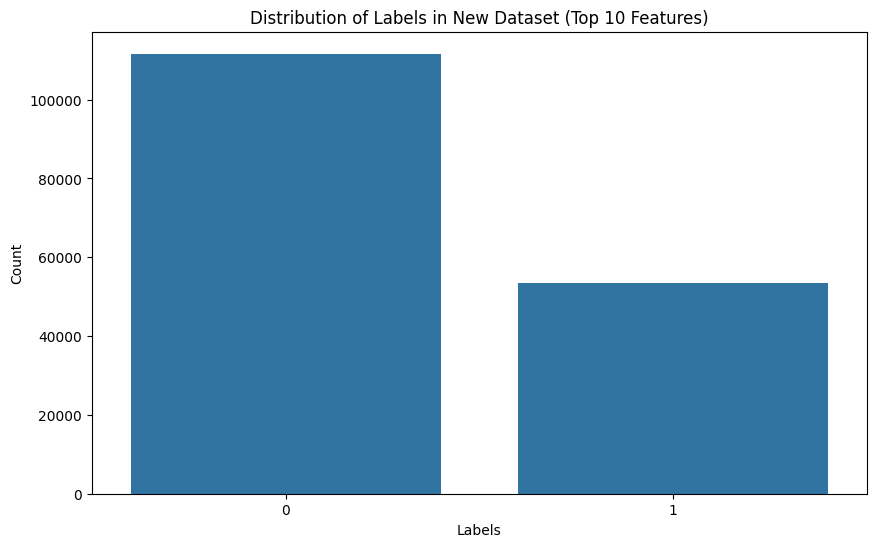

In [ ]:
y_top10_series = pd.Series(y_combined)  # Convert to pandas Series for easier counting

# Count occurrences of each label
label_counts = y_top10_series.value_counts()

# Print the label counts
print(label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.title('Distribution of Labels in New Dataset (Top 10 Features)')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined_df, y_combined, test_size=0.3, random_state=42, stratify=y_combined)

# Check the new distribution of labels
print("Label distribution:")
print(pd.Series(y_train).value_counts())

Label distribution:
0    78153
1    37491
Name: count, dtype: int64


In [ ]:
# Train a new RandomForest on the top 10 features
rf_top10_model_ft = RandomForestClassifier(random_state=42, n_estimators=65, max_samples=0.5, max_features=0.6, max_depth=9)

rf_top10_model_ft.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_top10_model_ft.predict(X_test)

accuracy_top10 = accuracy_score(y_test, y_pred)
recall_top10 = recall_score(y_test, y_pred)
precision_top10 = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy_top10}")
print(f"Recall: {recall_top10}")
print(f"Precision: {precision_top10}")

Accuracy: 0.9921312269233097
Recall: 0.9884241971620612
Precision: 0.9873181648638568


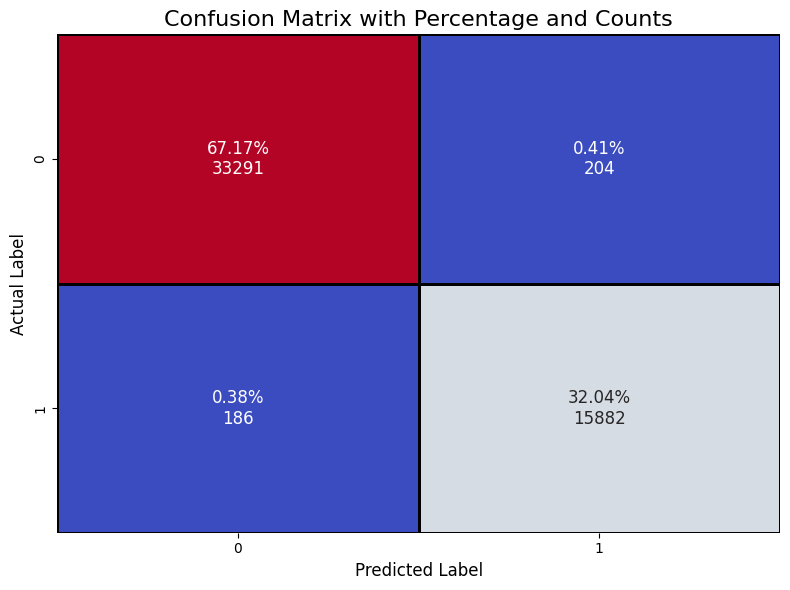

In [ ]:
# Confusion matrix
cross_top10 = pd.crosstab(pd.Series(y_test, name='Actual'),
                    pd.Series(y_pred, name='Predicted'))

# Calculate percentages
cross_percent_top10 = (cross_top10 / cross_top10.sum().sum() * 100).round(2)

# Create annotations with both percentages and counts
annotations_top10 = cross_percent_top10.astype(str) + "%\n" + cross_top10.astype(str)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cross_top10, annot=annotations_top10, fmt='', cmap="coolwarm", cbar=False,
            linewidths=1, linecolor='black', annot_kws={"size": 12})

# Add labels and title
plt.title('Confusion Matrix with Percentage and Counts', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.tight_layout()
plt.show()

# ⨋ Summary

### ⚛️ Making predictions

In [ ]:
#
#
#
# Making predictions when i get some data from rust sniffer
#
#
#

### 💾 Saving model

In [ ]:
import joblib

# Save the model to a file
model_filename = 'recondet_model.joblib'
joblib.dump(rf_top10_model_ft, model_filename)

['recondet_model.joblib']